MLP model

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load feature dataset
df = pd.read_csv("audio_features_extended.csv")

# Separate features and labels
X = df.drop("label", axis=1)
y = df["label"]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # One-hot encoding for classification

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

# Build a simple MLP model
model = Sequential([
    Dense(128, input_shape=(X.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.4f}")

# Save model, scaler, and encoder
model.save("audio_mlp_model.h5")
import joblib
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.4271 - loss: 0.7499 - val_accuracy: 0.5000 - val_loss: 0.6958
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5625 - loss: 0.7074 - val_accuracy: 0.5625 - val_loss: 0.6844
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5312 - loss: 0.6682 - val_accuracy: 0.6875 - val_loss: 0.6723
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6562 - loss: 0.6320 - val_accuracy: 0.6875 - val_loss: 0.6619
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7292 - loss: 0.6214 - val_accuracy: 0.6875 - val_loss: 0.6515
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7812 - loss: 0.5491 - val_accuracy: 0.6875 - val_loss: 0.6425
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8854 - loss: 0.5356 - val_accuracy: 0.6875 - val_loss: 0.6340
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7396 - loss: 0.5420 - val_accuracy: 0.6875 - val_loss: 0.6265
Ep

✅ Test Accuracy: 0.7500


['label_encoder.pkl']

prediction

In [5]:
import librosa
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# Load saved model and preprocessing tools
model = load_model("audio_mlp_model.h5")
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# Feature column order used during training
FEATURE_ORDER = [
    "mfcc_2", "mfcc_3", "mfcc_4", "mfcc_5", "mfcc_6",
    "mfcc_7", "mfcc_8", "mfcc_9", "mfcc_10", "mfcc_11",
    "mfcc_12", "mfcc_13", "zcr", "rms", "centroid",
    "bandwidth", "rolloff", "duration", "pitch_mean",
    "pitch_std", "energy_std"
]

def segment_audio_by_energy(y, sr, frame_duration=1.0, hop_duration=0.5, energy_threshold=0.01):
    frame_length = int(frame_duration * sr)
    hop_length = int(hop_duration * sr)
    segments = []
    for start in range(0, len(y) - frame_length, hop_length):
        end = start + frame_length
        segment = y[start:end]
        energy = np.mean(librosa.feature.rms(y=segment))
        if energy > energy_threshold:
            segments.append((start, end))
    return segments

def extract_features_from_segment(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_features = {f"mfcc_{i+1}": np.mean(mfccs[i]) for i in range(1, 13)}  # Skip mfcc_1

    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    rms = np.mean(librosa.feature.rms(y=y))
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    duration = librosa.get_duration(y=y, sr=sr)

    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitches = pitches[magnitudes > np.median(magnitudes)]
    pitch_mean = np.mean(pitches) if len(pitches) > 0 else 0
    pitch_std = np.std(pitches) if len(pitches) > 0 else 0
    energy_std = np.std(librosa.feature.rms(y=y)[0])

    features = {
        **mfcc_features,
        "zcr": zcr,
        "rms": rms,
        "centroid": centroid,
        "bandwidth": bandwidth,
        "rolloff": rolloff,
        "duration": duration,
        "pitch_mean": pitch_mean,
        "pitch_std": pitch_std,
        "energy_std": energy_std
    }

    # Ensure order consistency
    return pd.DataFrame([features])[FEATURE_ORDER]

def predict_labels_in_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    segments = segment_audio_by_energy(y, sr)

    results = []

    for idx, (start, end) in enumerate(segments):
        segment = y[start:end]
        features = extract_features_from_segment(segment, sr)
        features_scaled = scaler.transform(features)
        prediction = model.predict(features_scaled, verbose=0)
        predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
        results.append({
            "segment": idx + 1,
            "start_time": round(start / sr, 2),
            "end_time": round(end / sr, 2),
            "predicted_label": predicted_label
        })

    return results

# ===== Usage =====
file_path = "/content/WhatsApp Ptt 2025-05-29 at 3.07.39 PM.wav"
predictions = predict_labels_in_audio(file_path)

# Display results
for p in predictions:
    print(f"🧠 Segment {p['segment']} ({p['start_time']}s - {p['end_time']}s): {p['predicted_label']}")


🧠 Segment 1 (0.0s - 1.0s): command
🧠 Segment 2 (0.5s - 1.5s): dictation
🧠 Segment 3 (1.0s - 2.0s): command
🧠 Segment 4 (1.5s - 2.5s): dictation
🧠 Segment 5 (2.0s - 3.0s): dictation


audio visualization with prediction

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def visualize_audio_segments_with_labels(file_path, predictions):
    y, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)

    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.title("Audio Segments and Predicted Labels")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Compute y-axis max for label placement
    y_max = np.max(np.abs(y)) * 0.8

    for p in predictions:
        start, end = p["start_time"], p["end_time"]
        label = p["predicted_label"]
        color = 'orange' if label.lower() == 'command' else 'cyan'

        plt.axvspan(start, end, color=color, alpha=0.3)
        plt.text((start + end) / 2, y_max, label, ha='center', color='black', fontsize=10)

    plt.tight_layout()
    plt.show()


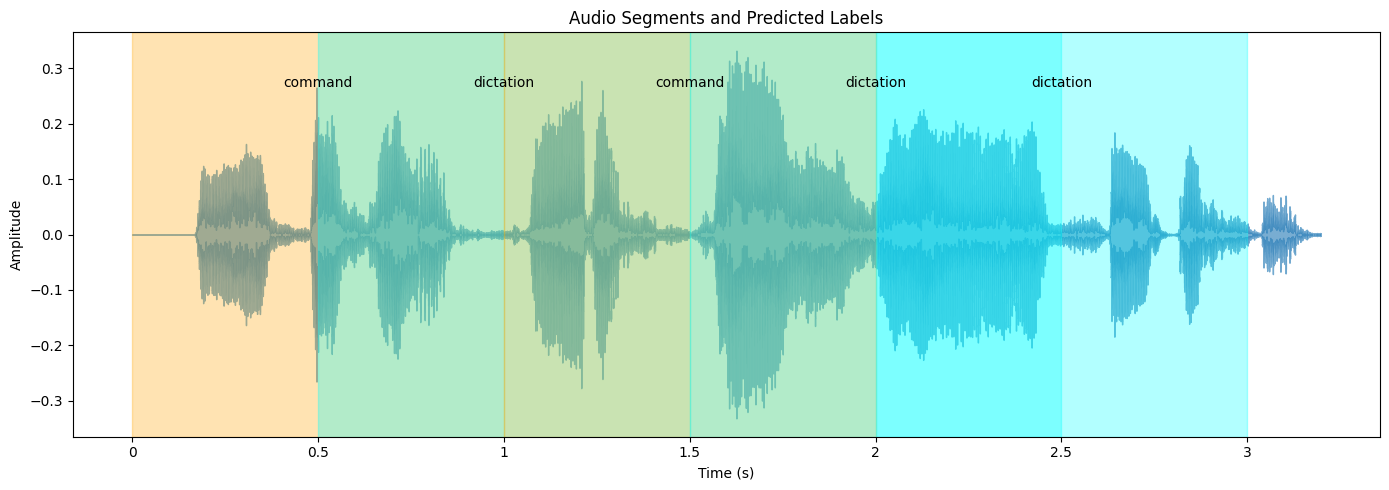

In [9]:
file_path = "/content/WhatsApp Ptt 2025-05-29 at 3.07.39 PM.wav"
predictions = predict_labels_in_audio(file_path)
visualize_audio_segments_with_labels(file_path, predictions)
